In [192]:
import pandas as pd
import os
import seaborn as sns
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, make_scorer, roc_curve, 
                             auc, average_precision_score, roc_auc_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
os.chdir('C:\\Users\\cinzi\\OneDrive\\Escritorio\\Big_Data_Complutense\\Machine Learning\\python')

In [3]:
#Todo Diciembre
df_dic_clientes= pd.read_csv('diciembre/clientes_diciembre.csv', sep='|')
df_dic_consumos= pd.read_csv('diciembre/consumos_diciembre.csv', sep='|')
df_dic_financiacion= pd.read_csv('diciembre/financiacion_diciembre.csv', sep='|')
df_dic_productos= pd.read_csv('diciembre/productos_diciembre.csv', sep='|')

In [4]:
#Todo Enero
df_ene_clientes = pd.read_csv('enero/clientes_enero.csv', sep='|')
df_ene_consumos = pd.read_csv('enero/consumos_enero.csv', sep='|')
df_ene_financiacion = pd.read_csv('enero/financiacion_enero.csv', sep='|')
df_ene_productos = pd.read_csv('enero/productos_enero.csv', sep='|')

In [5]:
df_dic_productos.id.duplicated().value_counts()

False    95467
Name: id, dtype: int64

In [6]:
(df_dic_productos.id==df_dic_clientes.id).value_counts()

True    95467
Name: id, dtype: int64

In [7]:
df_dic_clientes.id.duplicated().value_counts()

False    95467
Name: id, dtype: int64

In [8]:
df_dic_consumos.id.duplicated().value_counts()

False    95467
Name: id, dtype: int64

In [9]:
(df_dic_consumos.id==df_dic_clientes.id).value_counts()

True    95467
Name: id, dtype: int64

In [10]:
df_dic_financiacion.id.duplicated().value_counts()

False    24198
Name: id, dtype: int64

In [11]:
(df_ene_productos.id==df_ene_clientes.id).value_counts()

True    92711
Name: id, dtype: int64

In [12]:
(df_ene_consumos.id==df_ene_clientes.id).value_counts()

True    92711
Name: id, dtype: int64

Habiendo comprodado que no hay duplicados, se procede a unir las tablas. 


In [13]:
#Unión de dataset (diciembre)
df_dic_parcial=pd.merge(df_dic_clientes,df_dic_consumos, on='id', how='left')
df_dic_parcial= pd.merge(df_dic_parcial, df_dic_financiacion,on='id', how='left')
df_dic_total=pd.merge(df_dic_parcial, df_dic_productos,on='id', how='left')

In [14]:
#Unión de dataset (enero)

In [15]:
df_ene_parcial=pd.merge(df_ene_clientes,df_ene_consumos, on='id', how='left')
df_ene_parcial= pd.merge(df_ene_parcial, df_ene_financiacion,on='id', how='left')
df_ene_total=pd.merge(df_ene_parcial, df_ene_productos,on='id', how='left')

## Creación de la Target


In [16]:
df_dic_total['id'].isin(df_ene_total['id']).value_counts()

True     88382
False     7085
Name: id, dtype: int64

Para la creación de la variable objetivo se hace la comparación de los ids de ambos sets de datos,  los que coinciden se les asigna el 0 (que significa que el cliente ha permanecido), mientras que el 1 significa que el cliente ha abandonado y por consiguiente, será el objetivo a predecir.

*Lo que nos indica que 7085 clientes han abandonado la empresa*


In [17]:
target=df_dic_total['id'].isin(df_ene_total['id']).replace({True:0, False:1})
target

0        0
1        0
2        0
3        0
4        1
        ..
95462    0
95463    0
95464    0
95465    0
95466    0
Name: id, Length: 95467, dtype: int64

In [18]:
target=pd.DataFrame(target)

In [19]:
target=target.rename(columns={'id':'target'})

In [20]:
#Identificación de los datasets

df_dic_total['mes']='diciembre'
df_ene_total['mes']='enero'

In [21]:
df_dic_total['cant_dias'] = (datetime(2019,12,31) - pd.to_datetime(df_dic_total['antiguedad'])).dt.days
df_ene_total['cant_dias']=(datetime(2020,1,31)-pd.to_datetime(df_ene_total['antiguedad'])).dt.days

In [22]:
#Comunidades Autónomas con webscrapping de esta forma añadimos valor por agrupación de localidad

url='https://es.wikipedia.org/wiki/Provincia_(Espa%C3%B1a)'
r = requests.get(url).content
    

In [23]:
soup= BeautifulSoup(r, "html.parser" )
busqueda = soup.find('table', {'class':"wikitable sortable"})
table= pd.read_html(str(busqueda))
comunidad=table[0]
subcom=comunidad.loc[:, ['Provincia', 'Comunidad autónoma']]


In [24]:
subcom.columns= subcom.columns.str.lower()
subcom.provincia.replace(('Baleares'), ('Islas Baleares'), inplace= True)

In [25]:
FullData= pd.concat([df_dic_total, df_ene_total])

In [26]:
FullData.reset_index(inplace = True, drop = True)

In [27]:
FullData = pd.merge(FullData,subcom, how='left', on='provincia' )

In [28]:
 Tiempo= df_dic_total

## Análisis descriptivo de las variables 

In [29]:
FullData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188178 entries, 0 to 188177
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  188178 non-null  int64  
 1   edad                188178 non-null  int64  
 2   facturacion         188178 non-null  float64
 3   antiguedad          188178 non-null  object 
 4   provincia           188178 non-null  object 
 5   num_lineas          188178 non-null  int64  
 6   num_dt              7343 non-null    float64
 7   incidencia          5565 non-null    object 
 8   num_llamad_ent      188178 non-null  int64  
 9   num_llamad_sal      188178 non-null  int64  
 10  mb_datos            188178 non-null  int64  
 11  seg_llamad_ent      188178 non-null  int64  
 12  seg_llamad_sal      188178 non-null  int64  
 13  financiacion        13038 non-null   object 
 14  imp_financ          13038 non-null   float64
 15  descuentos          39192 non-null

Las variables: id, edad, facturación, antiguedad, provincia, num lineas, num llamadas ent, num llamadas sal, conexion, vel conexion y tv 
Aparentemente estas 14 variables no tienen datos faltantes. Sin embargo, se debe verificar las que poseen el tipo de variable objeto.
Las variables numero de lineas en impago, incidencia, descuentos,financiacion e	imp_financ, presentan datos faltantes. Sin embargo, esto era de esperarse,ya que estas  variables son instrumentos financieros que no todos los clientes pueden o quieren utilizar.

In [30]:
FullData.nunique()

id                     99796
edad                      68
facturacion            99799
antiguedad            187408
provincia                 50
num_lineas                 8
num_dt                     4
incidencia                 1
num_llamad_ent           251
num_llamad_sal           101
mb_datos               24985
seg_llamad_ent         19998
seg_llamad_sal         20001
financiacion               1
imp_financ              6696
descuentos                 1
conexion                   2
vel_conexion              14
TV                         3
mes                        2
cant_dias               9162
comunidad autónoma        17
dtype: int64

llama la atención las variables con solamente una categoría. Esto nos indica que probablemente estemos ante datos boleanos.

<AxesSubplot:>

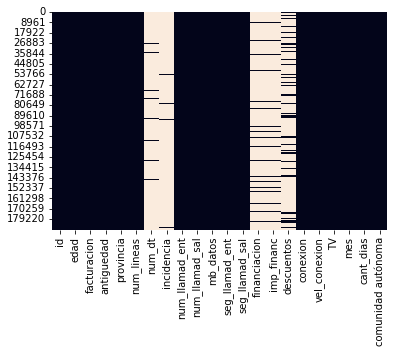

In [31]:
sns.heatmap(FullData.isnull(), cbar=False)

Como se había visto antes, era de esperarse que las variables numero de lineas en impago, incidencia, descuentos,financiacion e imp_financ tuviesen gran número de faltantes.Sin embargo, con el presente gráfico se puede descartar a priori algún tipo de correlación entre los datos nulos.


In [32]:
pd.set_option('display.max_rows', 1000)

In [33]:
df=FullData

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt



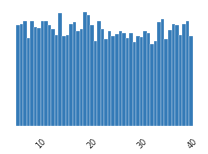

In [34]:
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

Luego de realizar el informe, para revisar un poco más a profundidad las variables que son categóricas, se procede a realizar los siguientes gráficos

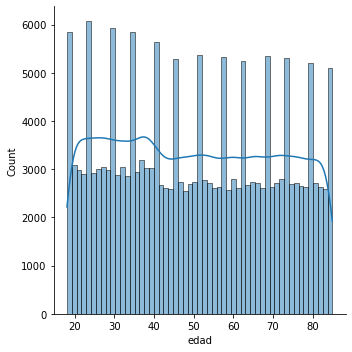

In [35]:
sns.displot(df['edad'],kind=("hist"), kde=True)



En el gráfico de frecuencias, se observan frecuencias elevadas en algunas edades. Sin embargo la línea del histograma refleja un comportamiendo mucho más constante, aunque se pueden diferenciar dos grupos: los menores de 40 años tienen una frecuencia más elevada que los mayores.
Para observar mejor este caso de las frecuencias elevadas, se procede a realizar una tabla de frecuencias y comprobar si hay datos con una frecuencia mucho más elevada que otros.


In [36]:
frec=pd.value_counts(df['edad']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['edad'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
84,2524,1.341283,1.341283
48,2556,1.358288,2.699572
59,2570,1.365728,4.065300
63,2577,1.369448,5.434748
85,2579,1.370511,6.805259
44,2589,1.375825,8.181084
80,2590,1.376356,9.557440
83,2597,1.380076,10.937517
45,2600,1.381671,12.319187
43,2602,1.382733,13.701921


Como se había observado anteriormente en la línea del histograma, las frecuencias de todas las edades que aparecen en la base de datos, son similares. Lo que lleva a concluir que no hay frecuencias elevadas en ciertas edades.

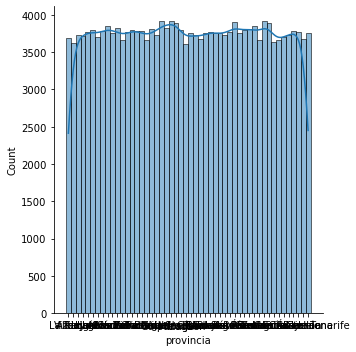

In [37]:
sns.displot(df['provincia'],kind=("hist"), kde=True)

In [38]:
frec=pd.value_counts(df['provincia']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['provincia'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
Huesca,3604,1.915208,1.915208
Vizcaya,3619,1.923179,3.838387
León,3635,1.931682,5.770069
Palencia,3657,1.943373,7.713442
Las Palmas,3658,1.943904,9.657346
Cantabria,3660,1.944967,11.602313
Toledo,3662,1.946030,13.548343
Cuenca,3679,1.955064,15.503406
Gerona,3680,1.955595,17.459002
La Rioja,3693,1.962504,19.421505


La frecuencia de aparición de la variable provincia, se encuetra balanceada. No hay outliers, ni NAs. Esta variable puede incluirse en el modelo sin ningún riesgo.

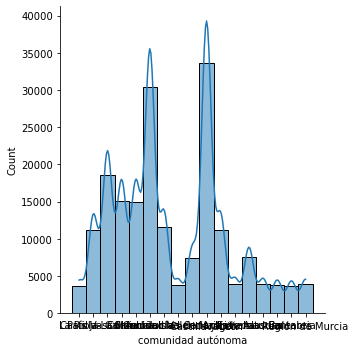

In [39]:
sns.displot(df['comunidad autónoma'],kind=("hist"), kde=True)

Este gráfico a diferencia del anterior si muestra una frecuencia superior en algunas comunidades a otras, por lo que esta variable ayuda a discretizar mucho mejor los datos, que la de las provincias.

In [40]:
frec=pd.value_counts(df['comunidad autónoma']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['comunidad autónoma'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
Cantabria,3660,1.944967,1.944967
La Rioja,3693,1.962504,3.907471
Comunidad de Madrid,3756,1.995983,5.903453
Islas Baleares,3763,1.999702,7.903156
Región de Murcia,3898,2.071443,9.974599
Asturias,3906,2.075694,12.050293
Navarra,3916,2.081008,14.131301
Islas Canarias,7446,3.956892,18.088193
Extremadura,7569,4.022256,22.110449
País Vasco,11232,5.968817,28.079265


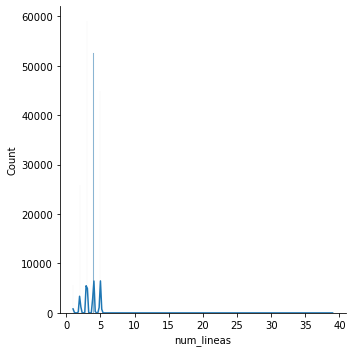

In [41]:
sns.displot(df['num_lineas'],kind=("hist"), kde=True)

In [42]:
frec=pd.value_counts(df['num_lineas']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['num_lineas'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
18,1,0.000531,0.000531
39,1,0.000531,0.001063
26,1,0.000531,0.001594
1,5611,2.981751,2.983346
2,25979,13.805546,16.788891
5,44955,23.889615,40.678507
4,52546,27.923562,68.602068
3,59084,31.397932,100.000000


Se observa que hay datos atípicos, no es muy unsual que un cliente tenga más de 5 líneas de móviles contratadas. Los valores altos pueden deberse a empresas que le entregan a sus trabajadores móviles para poder comunicarse por motivos laborales, a primera vista no parecen ser valores errados de digitación, ya que en las otras categorías no hay inconsistencias. Sin embargo, podrían quitarse estos valores, ya que su ocurrencia es insignificativa y para un modelo sería casi imposible detectar alguna correlación.

In [43]:
#Imputacion de valores atípicos con la moda

df['num_lineas']=(df['num_lineas']).replace(to_replace=[18, 39, 26],
           value=3)

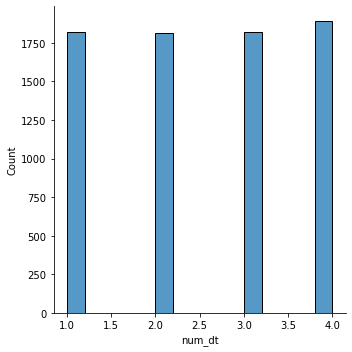

In [44]:
sns.displot(df['num_dt'],kind=("hist"), kde= False)

In [45]:
frec=pd.value_counts(df['num_dt']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['num_dt'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
2.0,1813,0.963449,0.963449
1.0,1817,0.965575,1.929025
3.0,1822,0.968232,2.897257
4.0,1891,1.004900,3.902156


la variable número de líneas en impago está balanceada, no hay valores atípicos y aunque haya gran número de faltantes, es de esperarse y es positivo, en este punto se refleja una buena salud financiera de la empresa en sus pasivos. Por lo tanto, esta variable se puede incluir en el modelo sin ninguna modificación o transformación.

In [46]:
frec=pd.value_counts(df['incidencia']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['incidencia'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
SI,5565,2.957306,2.957306


similar al caso anterior, era de esperarse que el número de incidencias sea bajo, y en este caso nos muestra la calidad de los productos de la empresa. Adicionalmente, cabe resaltar que no se realiza un gráfico de esta variable, porque al ser boleana, no tiene una representación gráfica explicativa que añada valor.

In [47]:
frec=pd.value_counts(df['financiacion']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['financiacion'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
SI,13038,6.928546,6.928546


se observa que el número de personas financiadas es solo un 7%, mientras que las que incurren en el impago están alrededor del 3%. Por lo que a simple vista podemos observar que un ~40% de las personas financiadas incurren en el impago, esto a futuro en el modelo nos puede conllevar a colinealidades en el modelo, se debe verificar con el VIF si es aceptable.

In [48]:
frec=pd.value_counts(df['descuentos']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['descuentos'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
SI,39192,20.827089,20.827089


Alrededor de un 21% de los clientes cuentan con algún tipo de descuento, lo que esto nos sugiere es que la empresa se encuentra bien posicionada, ya que no tiene que recurrir a descuentos como la fuente predominante para captar clientes. 

In [49]:
frec=pd.value_counts(df['conexion']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['conexion'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
FIBRA,92956,49.397910,49.397910
ADSL,95220,50.601027,99.998937


esta variable se encuentra balanceada, la cantidad de perdidos es mínima, por lo que se puede introducir en el modelo sin riesgo. En caso de ser necesario cualquier imputación sería buena.

In [50]:
frec=pd.value_counts(df['vel_conexion']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['vel_conexion'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
16598,1,0.000531,0.000531
1,1,0.000531,0.001063
?,1,0.000531,0.001594
15MB,15436,8.202872,8.204466
35MB,15619,8.300120,16.504586
30MB,15709,8.347947,24.852533
10MB,15776,8.383552,33.236085
25MB,15952,8.477080,41.713165
20MB,15995,8.499931,50.213096
100MB,18431,9.794450,60.007546


In [51]:
#se observa que en la conexión ADSL, la más frecuente es la de 20MB, por lo tanto la imputación puede hacerse por este valor para perjudicar lo menos posible a los datos
con_adsl= df.query('conexion=="ADSL"')
con_adsl.groupby('vel_conexion')['conexion'].count().sort_values(ascending=True)

vel_conexion
1            1
100MB      127
200MB      136
50MB       145
600MB      158
300MB      164
15MB     15436
35MB     15619
30MB     15708
10MB     15776
25MB     15952
20MB     15995
Name: conexion, dtype: int64

In [52]:
df['vel_conexion'] =df['vel_conexion'].replace('1', '20MB')

In [53]:
#En el caso de la conexión con Fibra el más repetido es el de 200 MB
con_Fibra= df.query('conexion=="FIBRA"')
con_Fibra.groupby('vel_conexion')['conexion'].count().sort_values(ascending=True)

vel_conexion
16598        1
?            1
100MB    18303
50MB     18496
300MB    18508
600MB    18763
200MB    18881
Name: conexion, dtype: int64

Se observa que hay datos con valores que no corresponden, como la incidencia es baja, se puede imputar con cualquier método, en este caso se procederá a imputar con la moda. Ya que es rápido, sencillo y eficiente.

In [54]:
df["vel_conexion"]=(df["vel_conexion"]).replace({'16598':'200MB'})
df["vel_conexion"]=(df["vel_conexion"]).replace({'?':'200MB'})
df["vel_conexion"].fillna("200MB", inplace = True) 
df['vel_conexion'].replace({'MB': ''}, inplace=True, regex=True)


In [55]:
df['vel_conexion'] = pd.to_numeric(df['vel_conexion'])

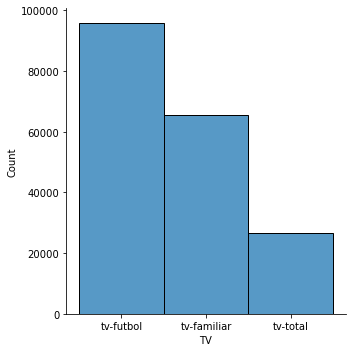

In [56]:
sns.displot(df['TV'],kind=("hist"), kde= False)

In [57]:
frec=pd.value_counts(df['TV']).sort_values()
frec_df=pd.DataFrame(frec)

frec_df.columns =["Frec_abs"]
frec_df['Frec_rel_%']= 100*frec_df["Frec_abs"]/len(df['TV'])
frec_rel_val= frec_df['Frec_rel_%'].values

acum= []
valor_acum = 0

for i in frec_rel_val:
    valor_acum = valor_acum +i
    acum.append(valor_acum)
    
frec_df["Frec_rel_%_acum"]= acum
frec_df

,Frec_abs,Frec_rel_%,Frec_rel_%_acum
tv-total,26785,14.233864,14.233864
tv-familiar,65568,34.843606,49.077469
tv-futbol,95825,50.922531,100.000000


## Limpieza y Preprocesamiento

No se presentan datos faltantes, ni valores extremos. Adicionalmente, cabe resaltar que más de la mitad de los clientes  tienen el paquete de futbol para la TV.

#### Para realizar nuestro primer modelo se deben codificar todas las variables que son categóricas, ya que el modelo requiere un input numérico

In [58]:
list(set(df.provincia))

['Córdoba',
 'Albacete',
 'Toledo',
 'Salamanca',
 'Tarragona',
 'Granada',
 'Ciudad Real',
 'Asturias',
 'Murcia',
 'Zaragoza',
 'La Coruña',
 'Lérida',
 'Jaén',
 'Orense',
 'Soria',
 'Sevilla',
 'Huesca',
 'Palencia',
 'Cuenca',
 'Álava',
 'León',
 'Guipúzcoa',
 'Alicante',
 'Vizcaya',
 'Lugo',
 'Teruel',
 'Valencia',
 'Badajoz',
 'Ávila',
 'Valladolid',
 'Málaga',
 'Cantabria',
 'Barcelona',
 'Islas Baleares',
 'Santa Cruz de Tenerife',
 'Castellón',
 'Gerona',
 'Zamora',
 'Navarra',
 'Cádiz',
 'Cáceres',
 'Burgos',
 'Madrid',
 'Segovia',
 'Las Palmas',
 'Almería',
 'Huelva',
 'Guadalajara',
 'Pontevedra',
 'La Rioja']

###### Todas las variables categóricas son nominales con la excepción de vel_conexión, por lo tanto el tipo de codificación que les corresponde es one-hot.Sin embargo, la creación de dummies por cada categoría-1, haría que la base de datos creciera desproporcionadamente (a concieración propia), para la  variable(provincia ). Por tal motivo, las variables con 1 categoría se condificaran como boleanas, las de 3 categorías one-hot, y las mayores con una codificación ordinal. Por último, la variable "antiguedad", se transformará a año para trabajarla como entero


In [59]:
#Creación de variables 
df['antiguedad']= pd.to_datetime(df['antiguedad']).dt.year


In [60]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[['La Rioja',
 'Valencia',
 'Ávila',
 'Asturias',
 'Huelva',
 'Burgos',
 'Jaén',
 'Castellón',
 'Alicante',
 'Cantabria',
 'Toledo',
 'Barcelona',
 'Segovia',
 'Huesca',
 'Palencia',
 'Lugo',
 'Salamanca',
 'Álava',
 'Madrid',
 'Guipúzcoa',
 'Lérida',
 'Murcia',
 'Las Palmas',
 'León',
 'Córdoba',
 'La Coruña',
 'Guadalajara',
 'Cuenca',
 'Albacete',
 'Navarra',
 'Tarragona',
 'Gerona',
 'Zamora',
 'Cádiz',
 'Ciudad Real',
 'Badajoz',
 'Pontevedra',
 'Orense',
 'Zaragoza',
 'Almería',
 'Valladolid',
 'Málaga',
 'Sevilla',
 'Islas Baleares',
 'Cáceres',
 'Granada',
 'Vizcaya',
 'Soria',
 'Teruel',
 'Santa Cruz de Tenerife']])


In [61]:
# Ajustamos el codificador con la variable education y la transformamos
encoder.fit(df[["provincia"]])
df["provincia"] = encoder.transform(df[["provincia"]])

In [80]:
# Creamos el codificador indicandole el orden de la variables
encoder = OrdinalEncoder(categories=[['La Rioja', 'País Vasco', 'Castilla-La Mancha', 'Galicia',
       'Cataluña', 'Andalucía', 'Comunidad Valenciana',
       'Comunidad de Madrid', 'Islas Canarias', 'Castilla y León',
       'Aragón', 'Navarra', 'Extremadura', 'Asturias', 'Islas Baleares',
       'Cantabria', 'Región de Murcia']])

In [81]:
# Ajustamos el codificador con la variable education y la transformamos
encoder.fit(df[['comunidad autónoma']])
df['comunidad autónoma'] = encoder.transform(df[['comunidad autónoma']])

In [62]:
df["incidencia"].fillna(0, inplace = True) 

In [63]:
df["incidencia"]=(df["incidencia"]).replace({'SI':1})

In [64]:
df["financiacion"].fillna(0, inplace = True) 

In [65]:
df["financiacion"]=(df["financiacion"]).replace({'SI':1})

In [66]:
df["descuentos"].fillna(0, inplace = True) 

In [67]:
df["descuentos"]=(df["descuentos"]).replace({'SI':1})

In [68]:
df["conexion"]=(df["conexion"]).replace({'ADSL':1})

In [69]:
df["conexion"]=(df["conexion"]).replace({'FIBRA':2})

In [70]:
df["conexion"].fillna(1, inplace = True) 

In [71]:
df["imp_financ"].fillna(0, inplace = True) 

In [72]:
df["num_dt"].fillna(0, inplace = True) 

In [73]:
dummy_TV = pd.get_dummies(df["TV"], prefix= "TV")


In [83]:
df.isnull().sum()
df_VIF=df 

In [84]:
df_VIF['TV']=df_VIF['TV'].replace({'tv-total':0, 'tv-familiar':2, 'tv-futbol':3}, inplace=True)

In [85]:
df=pd.concat([df, dummy_TV], axis=1)


In [86]:
df=df.drop(['TV'], axis=1)

### Factor de Inflacion de Varianza (VIF)

con este factor se comprueba si existe multicolinealidad, con ello evitamos añadir más de una variable que explique un mismo comportamiento de la respuesta 

In [87]:
def CalculadorVIF(datos):
    caracteristic = list(datos.columns)
    
    len_car = len(caracteristic)
    
    VIF = pd.DataFrame(index = ['VIF'], columns = caracteristic)
    
    VIF = VIF.fillna(0)
    
    for i in range(len_car):
        x_car = caracteristic[:]
        y_car = caracteristic[i]
        x_car.remove(y_car)
        
        x = datos[x_car]
        y = datos[ y_car]
        model = LinearRegression()
        model.fit(datos[x_car], datos[ y_car])
        
        VIF[y_car] = 1/(1 - model.score(datos[x_car], datos[ y_car]))
    
    return VIF

    

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188178 entries, 0 to 188177
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  188178 non-null  int64  
 1   edad                188178 non-null  int64  
 2   facturacion         188178 non-null  float64
 3   antiguedad          188178 non-null  int64  
 4   provincia           188178 non-null  float64
 5   num_lineas          188178 non-null  int64  
 6   num_dt              188178 non-null  float64
 7   incidencia          188178 non-null  int64  
 8   num_llamad_ent      188178 non-null  int64  
 9   num_llamad_sal      188178 non-null  int64  
 10  mb_datos            188178 non-null  int64  
 11  seg_llamad_ent      188178 non-null  int64  
 12  seg_llamad_sal      188178 non-null  int64  
 13  financiacion        188178 non-null  int64  
 14  imp_financ          188178 non-null  float64
 15  descuentos          188178 non-nul

In [89]:
dfVif = df_VIF.copy(deep = True)
caracteristica = list(df_VIF.columns)
caracteristica.remove('mes')
caracteristica.remove('TV')
df_vif = dfVif[caracteristica]
CalculadorVIF(df_vif)

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,cant_dias,comunidad autónoma
VIF,1.000336,1.00652,1.271432,613.229155,1.001431,1.270994,1.009712,1.009453,1.000099,1.000167,1.000079,1.000159,1.000216,5.468743,5.466051,1.010409,1.669751,1.669056,613.227831,1.001426


Como se había mencionado con anterioridad, la financiación y el impago tienen una multicolinealidad alta, por tal motivo, es ideal quitar una de ellas. Como cabe de esperarse que a mayor número de lídeas en impago, será mayor la probabilidad de abandono de la compañía y el VIF es inferior al de la financiación, se procederá a eliminar la variable financiación del modelo. El resto de variables tiene un VIF bueno.

### Modelado 

In [90]:
dftrain = df[df['mes']=='diciembre']
dftest = df[df['mes']=='enero']
dftrain.drop('mes', axis=1, inplace=True)
dftest.drop('mes', axis=1, inplace=True)

C:\Users\cinzi\AppData\Local\Temp\ipykernel_22756\325191542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftrain.drop('mes', axis=1, inplace=True)
C:\Users\cinzi\AppData\Local\Temp\ipykernel_22756\325191542.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest.drop('mes', axis=1, inplace=True)


## MODELO 1

In [91]:
x = dftrain
y = target
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.33,random_state=1)

In [92]:
def metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[28924   179]
 [ 1329  1073]]
accuracy
0.9521345818124107
precision
0.8570287539936102
recall
0.44671107410491256
f1
0.5873015873015872
AUC
0.720280252717508


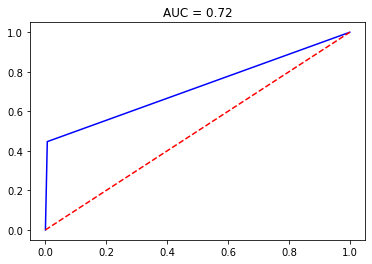

In [93]:
model1 = make_pipeline(StandardScaler(), LogisticRegression())
model1.fit(x_train, y_train)
y_pred     = model1.predict(x_test)
metricas(y_test, y_pred)

In [95]:
df_corr= pd.concat([dftrain, target], axis=1)

In [96]:
df_corr = abs(df_corr.corr())

In [97]:
df_corr[['target']].sort_values(by = 'target',ascending = False).style.background_gradient()

,target
target,1.000000
num_dt,0.312795
edad,0.296835
incidencia,0.277408
TV_tv-futbol,0.152493
descuentos,0.141447
TV_tv-total,0.111106
TV_tv-familiar,0.079990
financiacion,0.074597
imp_financ,0.067626


Se puede apreciar que las variables más influyentes son el número de lineas de impago, la edad, la incidencia, descuento. Estas  variables explican más del 80% de la predicción. Por tal motivo, para mejorar el modelo y hacerlo más simple se puede reducir el número de variables (quitando id que sabemos que no tiene ninguna relación con el target y todas las siguientes al id)

## MODELO 2


In [116]:
df_simple= dftrain[['edad', 'facturacion', 'antiguedad', 'num_lineas',
       'num_dt', 'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos','financiacion', 'imp_financ',
       'descuentos', 'conexion', 'vel_conexion',
       'comunidad autónoma', 'TV_tv-familiar', 'TV_tv-futbol', 'TV_tv-total']]

In [144]:
df_simple['mes_Antiguedad']=(Tiempo['antiguedad']).dt.month
df_simple['dia_Antiguedad']=Tiempo['antiguedad'].dt.dayofweek
df_simple['hora_Antiguedad']=(Tiempo['antiguedad']).dt.hour

In [131]:
def f(x):
    if (x > 4) and (x <= 8):
        return 1
    elif (x > 8) and (x <= 12 ):
        return 2
    elif (x > 12) and (x <= 16):
        return 3
    elif (x > 16) and (x <= 20) :
        return 4
    elif (x > 20) and (x <= 24):
        return 5
    elif (x <= 4):
        return 6

In [132]:
 df_simple['turno']=df_simple['hora_Antiguedad'].apply(f)

In [102]:
df_simple['antiguedad_real']= (pd.to_datetime('2019-12-31')-pd.to_datetime(Tiempo['antiguedad'])).dt.days


C:\Users\cinzi\AppData\Local\Temp\ipykernel_22756\544382600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simple['antiguedad_real']= (pd.to_datetime('2019-12-31')-pd.to_datetime(Tiempo['antiguedad'])).dt.days


In [151]:
list_corr=['edad', 'facturacion', 'antiguedad', 'num_lineas', 'num_dt',
       'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'financiacion', 'imp_financ', 'descuentos', 'conexion', 'vel_conexion',
       'cant_dias', 'comunidad autónoma', 'TV_tv-familiar', 'TV_tv-futbol',
       'TV_tv-total', 'mes_Antiguedad', 'dia_Antiguedad', 'hora_Antiguedad',
       'turno']


df_corr= df_simple[list_corr]

<AxesSubplot:>

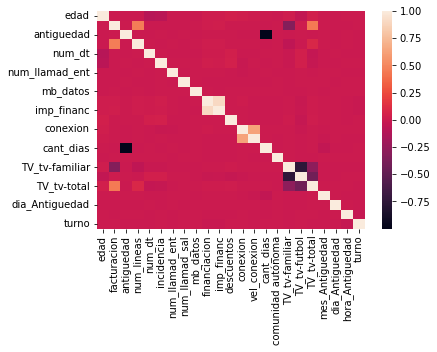

In [159]:
matrix= df_corr.corr()
sns.heatmap(matrix)

#Existe correlacion negativa entre facturación y tv-familiar. Por lo que se puede decir que los que tienen la tv familiar, pagan menos que aquellos que tienen otros servicios contratados

In [160]:
x = df_simple
y = target
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.33,random_state=1)

C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


matriz de confusión
[[28927   176]
 [ 1328  1074]]
accuracy
0.9522615457863831
precision
0.8592
recall
0.44712739383846795
f1
0.588170865279299
AUC
0.720539953662525


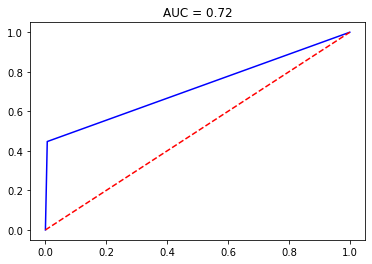

In [161]:
model2 = make_pipeline(StandardScaler(), LogisticRegression(solver='newton-cg'))
model2.fit(x_train, y_train)
y_pred2     = model2.predict(x_test)
metricas(y_test, y_pred)

In [162]:
df_corr= pd.concat([df_simple, target], axis=1)

In [163]:
df_corr = abs(df_corr.corr())

In [164]:
df_corr[['target']].sort_values(by = 'target',ascending = False).style.background_gradient()

,target
target,1.000000
num_dt,0.312795
edad,0.296835
incidencia,0.277408
TV_tv-futbol,0.152493
descuentos,0.141447
TV_tv-total,0.111106
TV_tv-familiar,0.079990
financiacion,0.074597
imp_financ,0.067626


C:\Users\cinzi\AppData\Local\Temp\ipykernel_22756\1472012702.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3 = RandomForestClassifier(n_estimators=200, max_depth=8).fit(x_train, y_train)


matriz de confusión
[[28959   144]
 [ 1156  1246]]
accuracy
0.9587367084589747
precision
0.8964028776978418
recall
0.5187343880099917
f1
0.6571729957805907
AUC
0.7568932222495067


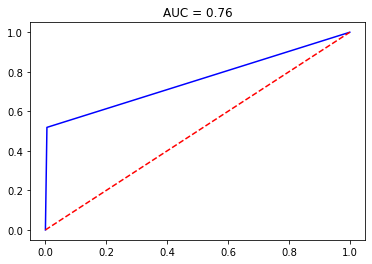

In [165]:
model3 = RandomForestClassifier(n_estimators=200, max_depth=8).fit(x_train, y_train)
y_pred3        = model3.predict(x_test)
metricas(y_test, y_pred)

In [166]:
model3_param = RandomForestClassifier(criterion='gini', max_depth=8).fit(x_train, y_train)
y_pred3       = model3_param.predict(x_test)

C:\Users\cinzi\AppData\Local\Temp\ipykernel_22756\30973398.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model3_param = RandomForestClassifier(criterion='gini', max_depth=8).fit(x_train, y_train)


In [167]:
importance = model3_param.feature_importances_
importance
for i,v in enumerate(importance):
  print(x_test.columns[i], '%d Score: %.5f' % (i,v))

edad 0 Score: 0.28676
facturacion 1 Score: 0.00746
antiguedad 2 Score: 0.00184
num_lineas 3 Score: 0.00100
num_dt 4 Score: 0.24929
incidencia 5 Score: 0.18343
num_llamad_ent 6 Score: 0.00352
num_llamad_sal 7 Score: 0.00238
mb_datos 8 Score: 0.00370
financiacion 9 Score: 0.01736
imp_financ 10 Score: 0.01936
descuentos 11 Score: 0.09706
conexion 12 Score: 0.00599
vel_conexion 13 Score: 0.02924
cant_dias 14 Score: 0.00372
comunidad autónoma 15 Score: 0.00222
TV_tv-familiar 16 Score: 0.01208
TV_tv-futbol 17 Score: 0.04580
TV_tv-total 18 Score: 0.02237
mes_Antiguedad 19 Score: 0.00149
dia_Antiguedad 20 Score: 0.00105
hora_Antiguedad 21 Score: 0.00189
turno 22 Score: 0.00100


 Hay mejora. Sin embargo en este modelo tenemos que ser especialmente cuidadosos con el sobreajuste. Para validar estos resultados, procedemos a realizar una validación cruzada 

In [169]:
cv_scores = cross_val_score(
                estimator = model3_param,
                X         = x_train,
                y         = y_train,
                cv        = 5
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y wa

Métricas validación cruzada: [0.95989995 0.96201047 0.96161664 0.9620075  0.96146029]
Média métricas de validación cruzada: 0.9613989695056322


Los resultados de la validación cruzada nos muestran que no hubo sobreajuste en el modelo, y que se puede confiar en la precisión del 96%. Si quisieramos mayor seguridad, se podría utilizar la validación cruzada repetida

## Mejora de Modelos

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [182]:
f1_scorer = make_scorer(f1_score)
pipe = Pipeline([
    ('classify', RandomForestClassifier(random_state=1, n_estimators=100))
])
maxdepth_grid = [ 6, 8, 10, 12, 14]
param_grid = [
    {'classify__max_depth': maxdepth_grid },
]
clf  = GridSearchCV(pipe, cv=10, n_jobs=2, param_grid=param_grid, verbose=1, 
                    return_train_score=True, scoring=f1_scorer)


In [183]:
clf.fit(x_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\pipeline.py:382: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classify',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=2, param_grid=[{'classify__max_depth': [6, 8, 10, 12, 14]}],
             return_train_score=True, scoring=make_scorer(f1_score), verbose=1)

In [184]:
clf.best_params_

{'classify__max_depth': 14}

In [185]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Maximum number of levels in tree
max_depth = [8,10,12]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [186]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_depth': [8, 10, 12], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [187]:
rf_Model = RandomForestClassifier()

In [188]:
rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)

In [189]:
rf_Grid.fit(x_train, y_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


C:\Users\cinzi\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [True, False], 'max_depth': [8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72,
                                          80]},
             verbose=2)

In [190]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 64}

In [191]:
print (f'Train Accuracy - : {rf_Grid.score(x_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_Grid.score(x_test,y_test):.3f}')

Train Accuracy - : 0.963
Test Accuracy - : 0.959


In [204]:
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

In [222]:
modelos={
    "Random":RandomForestClassifier(n_estimators=30, n_jobs=1, random_state=1),
    "Tree":DecisionTreeClassifier(random_state=1),
    "XGB":XGBClassifier(n_jobs=1, n_estimators=30, random_state= 1),
    "Log":LogisticRegression(solver='newton-cg'),}
                              

In [229]:
def comparar(model, X_train, Y_train):
    resultado= []
    nombre= []
    
    for i, Y in model.items():
        
        m = RepeatedStratifiedKFold(n_splits=15, n_repeats=5, random_state=1)
        cv= cross_val_score(Y, X_train, Y_train, scoring='roc_auc', cv=m, n_jobs=-1)
        
        resultado.append(cv)
        nombre.append(i)
        print(i)
        print(np.mean(cv), np.std(cv))
        
    return(resultado, nombre)

resultado, nombre = comparar(modelos, x_train, y_train)



Random
0.9556789373686759 0.0035647946841890397
Tree
0.7844293249737796 0.00963743795418749
XGB
0.9674963588068677 0.0018535163067835616
Log
0.9525037463010165 0.002437307730533481


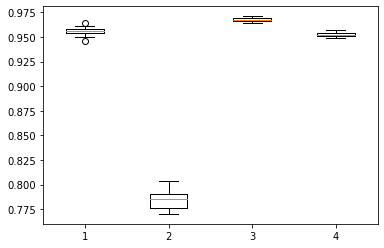

In [230]:
compare =plt.boxplot(resultado)

## Predicción

In [272]:
predic=model3_param.predict_proba(x_test)[:,1]

In [273]:
predic = (pd.DataFrame(predic,columns=['prob'],index=x_test.index))

In [276]:
predic

,prob
2862,0.821003
2784,0.802668
2655,0.792687
17114,0.787154
57512,0.785679
...,...
74195,0.000000
84487,0.000000
53093,0.000000
53821,0.000000


In [275]:
predic.sort_values(by=['prob'],ascending=False,axis=0,inplace=True)

In [277]:
x_test.reset_index(inplace=True)

In [342]:
x_test

,index,edad,facturacion,antiguedad,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,...,vel_conexion,cant_dias,comunidad autónoma,TV_tv-familiar,TV_tv-futbol,TV_tv-total,mes_Antiguedad,dia_Antiguedad,hora_Antiguedad,turno
0,80665,29,368.098664,2000,3,0.0,0,206,73,1157,...,15,7039,1.0,0,1,0,9,3,1,6
1,72228,31,218.603408,2001,4,2.0,1,105,65,19868,...,25,6649,3.0,0,1,0,10,1,17,4
2,48582,32,147.437891,2000,5,0.0,0,169,53,18764,...,25,7197,8.0,1,0,0,4,6,23,5
3,65718,47,58.758363,2008,4,0.0,0,45,57,14509,...,50,4102,8.0,0,1,0,10,0,19,4
4,6333,78,329.927974,2015,3,0.0,0,248,78,10986,...,50,1608,3.0,0,1,0,8,2,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31500,69142,18,315.551951,1998,4,0.0,0,227,15,11077,...,20,7894,5.0,0,1,0,5,2,16,3
31501,44662,19,175.145960,2012,2,0.0,0,217,26,12528,...,35,2914,2.0,0,0,1,1,5,7,1
31502,90354,47,286.116761,2004,5,0.0,0,215,97,22206,...,35,5695,1.0,1,0,0,5,3,8,1
31503,38655,53,232.543344,2000,4,0.0,0,106,30,5095,...,600,7090,3.0,1,0,0,8,1,9,2


In [279]:
predic.reset_index(inplace=True)

Se añade la columna prob, donde se muestra la probabilidad por id de cliente de que este se fuge, dependiendo de la necesidad de la compañía se puede ajustar para que una probabilidad inferior al 0.5, se tome como alta y se ejecuten acciones. Sin embargo, lo ususal es transformar las probabilidades superiores a 0.5 en 1 y las inferiores en 0.

## Explicación de Variables (importantes)

<AxesSubplot:>

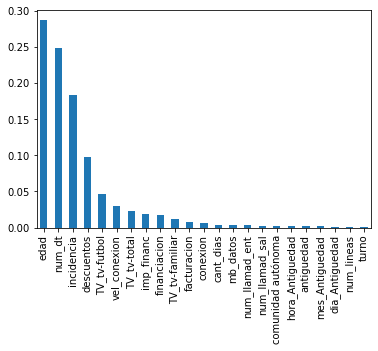

In [286]:
feature_imp = pd.Series(model3_param.feature_importances_, index = x_train.columns).sort_values(ascending=False)
feature_imp.plot(kind='bar')

Ya que la edad no parecía ser un factor bueno para discriminar a priori, se puede realizar una matriz de correlación solamente entre la variable objetivo y la variable edad que es numérica, para confirmar que existe una relación

In [324]:
full_predic = pd.merge(x_test, predic, on= ['index'])

In [349]:
comprobacion = pd.concat([x_train, target],axis=1)

<AxesSubplot:>

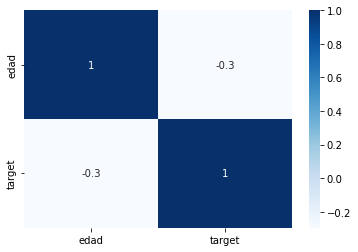

In [350]:
m= comprobacion[['edad','target']].corr()
sns.heatmap(m, cmap="Blues", annot=True, annot_kws={"size": 10} )


<AxesSubplot:>

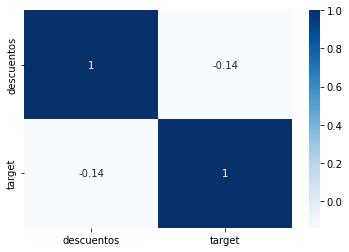

In [351]:
m= comprobacion[['descuentos','target']].corr()
sns.heatmap(m, cmap="Blues", annot=True, annot_kws={"size": 10} )

En órden de importancia las variables son: 

Edad:esta es una variable muy influyente, entre menor sea la edad del cliente, este tiene una mayor probabilidad de fugarse.
Número de líneas de impago: a mayor número de líneas en impago, mayor es la probabilidad de abandono.
Incidencia: las insatisfacciones de los clientes en el servicio, o capacidad de resolución del personal de atención al cliente a estas incidencias, tiene una gran repercusión en la permanencia.
Descuentos: esta variable tiene una correlación negativa, como era de esperarse. Lo que significa que entre mayor sea el descuento que tiene el cliente, es menor su probabilidad de fugarse.
tv_futbol:las personas que tienen contratada la tv para ver el futbol, tienen una mayor probabilidad de fugarse.
vel_conexion: aunque no es muy relevante, tiene un comportamiento de correlación directa. A mayor velocidad de conexión, es más probable que el cliente se fuge. Aunque no sea de las variables que repercuten más, nos da infomación sobre el servicio, y sobretodo de los clientes que están pagando más por ellos. 

